In [1]:
import tensorflow as tf
import tensorflow.keras as K

In [2]:
def convNet(x,filters,resNet=0,maxPool=1):
    if resNet:
        skip=x
        x=K.layers.Conv2D(filters//2,3,padding="same")(x)
    else:
        x=K.layers.Conv2D(filters,3,padding="same")(x)
    x=K.layers.BatchNormalization()(x)
    x=K.layers.LeakyReLU()(x)
#     x=K.layers.MaxPool2D()(x)
#     x=K.layers.Conv2D(filters,3,padding="same")(x)
#     x=K.layers.BatchNormalization()(x)
#     x=K.layers.LeakyReLU()(x)
    
    tf.print(x.shape)
    if resNet:
        x=K.layers.Concatenate(axis=-1)([x,skip])
    if maxPool:
        x=K.layers.MaxPool2D(2,2,'same')(x)
    return x
    

In [7]:
# Based off https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9074315
input=K.Input(shape=(416,416,3))
x=convNet(input,16)
x=convNet(x,32,1)
x=convNet(x,64,1)
x=convNet(x,128,1)
x=convNet(x,256,1,0)
concat=x
x=K.layers.MaxPool2D(2,2,'same')(x)
x=convNet(x,512,1,0)
x=convNet(x,1024,1,0)
# x=K.layers.Conv2D(1024,3,padding="same")(x)
# x=K.layers.BatchNormalization()(x)
# x=K.layers.LeakyReLU()(x)
split=K.layers.Conv2D(256,1,padding="same")(x)
split=K.layers.BatchNormalization()(split)
split=K.layers.LeakyReLU(name="split")(split)
output_13=convNet(split,512,1,0)
# output_13=K.layers.Conv2D(512,3,padding="same")(split)
# output_13=K.layers.BatchNormalization()(output_13)
# output_13=K.layers.LeakyReLU()(output_13)
output_13=K.layers.Conv2D(168+80+1,1,padding="same",name="output_13")(output_13)
output_13=K.layers.Activation("tanh")(output_13)
output_26=K.layers.Conv2D(256,1,padding="same")(split)
output_26=K.layers.BatchNormalization()(output_26)
output_26=K.layers.LeakyReLU()(output_26)
output_26=K.layers.UpSampling2D()(output_26)
output_26=K.layers.Conv2D(128,1,padding="same")(output_26)
output_26=K.layers.BatchNormalization()(output_26)
output_26=K.layers.LeakyReLU()(output_26)
output_26=K.layers.Concatenate(axis=-1)([output_26,concat])
output_26=K.layers.Conv2D(256,3,padding="same")(output_26)
output_26=K.layers.BatchNormalization()(output_26)
output_26=K.layers.LeakyReLU()(output_26)
output_26=K.layers.Conv2D(168+80+1,1,padding="same",name="output_26")(output_26)
output_26=K.layers.Activation("tanh")(output_26)
model=K.Model(inputs=input,outputs=[output_13,output_26],name="YOLO-PV")

TensorShape([None, 416, 416, 16])
TensorShape([None, 208, 208, 16])
TensorShape([None, 104, 104, 32])
TensorShape([None, 52, 52, 64])
TensorShape([None, 26, 26, 128])
TensorShape([None, 13, 13, 256])
TensorShape([None, 13, 13, 512])
TensorShape([None, 13, 13, 256])


In [10]:
model.summary()

Model: "YOLO-PV"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 416, 416, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 416, 416, 16) 64          conv2d_12[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 416, 416, 16) 0           batch_normalization_12[0][0]     
____________________________________________________________________________________________

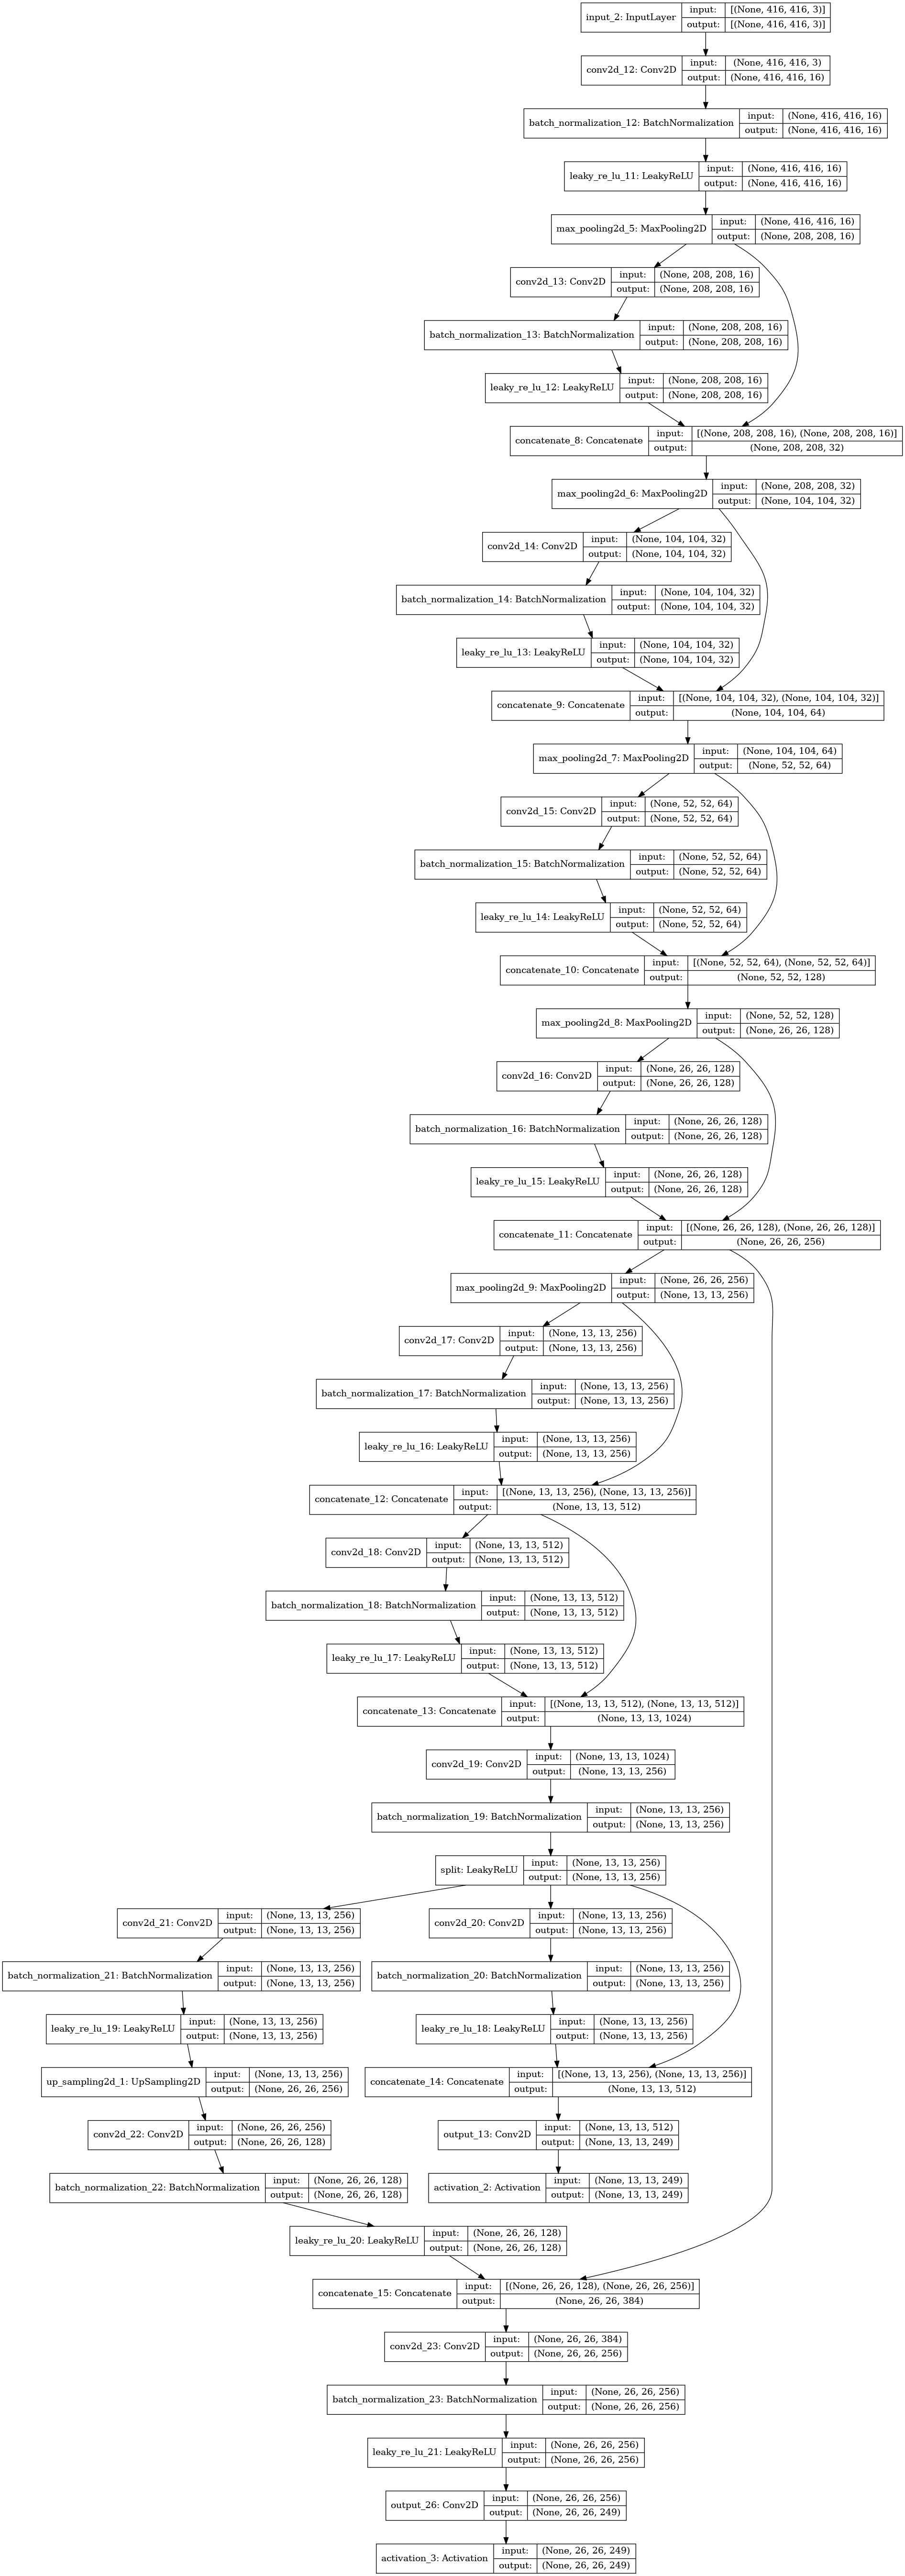

In [8]:
import pydot,graphviz
tf.keras.utils.plot_model(model, show_shapes=True)

In [6]:
# !install graphviz